In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jcopdl
import luwiji

In [2]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Dataset & Dataloader

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [4]:
bs = 128
crop_size = 64

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size,scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

#Test jangan di transform aneh2 , cukup di resize aja
test_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)

test_set = datasets.ImageFolder("data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [5]:
feature, target = next(iter(trainloader))
feature.shape #check N,C,H,W (N, Channel, Height, Weight)

torch.Size([128, 3, 64, 64])

In [6]:
label2cat = train_set.classes
label2cat

['invasive', 'noninvasive']

### Arsitektur & Config

In [7]:
#Kalau manual tanpa conv_block

# nn.Conv2d(in_channels=3,
#           out_channels=8,
#           kernel_size=3,
#           stride=1,
#           padding=1),
# nn.ReLU(),
# nn.MaxPool2d(2,2)

In [9]:
from jcopdl.layers import conv_block,linear_block

In [10]:
class CustomCNNku(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            conv_block(3,8),
            conv_block(8,16),
            conv_block(16,32),
            conv_block(32,64),
            nn.Flatten()
        )
        
        self.fc = nn.Sequential(
            linear_block(1024, 256,dropout=0.1),
            linear_block(256, 2 , activation='lsoftmax')
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [11]:
config = set_config({
    "batch_size" : bs,
    "crop_size" : crop_size
})

### Training Prep >> MCOC

In [12]:
model = CustomCNNku().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

### Training 

In [13]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.6919 | Test_cost  = 0.6831 | Train_score = 0.5300 | Test_score = 0.5000 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.6656 | Test_cost  = 0.6208 | Train_score = 0.6420 | Test_score = 0.7075 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.5854 | Test_cost  = 0.5912 | Train_score = 0.7190 | Test_score = 0.6575 |
==> EarlyStop patience =  1 | Best test_score: 0.7075


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.5453 | Test_cost  = 0.5709 | Train_score = 0.7310 | Test_score = 0.6825 |
==> EarlyStop patience =  2 | Best test_score: 0.7075


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.5174 | Test_cost  = 0.5045 | Train_score = 0.7520 | Test_score = 0.7375 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.4926 | Test_cost  = 0.4732 | Train_score = 0.7670 | Test_score = 0.7925 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.4814 | Test_cost  = 0.4629 | Train_score = 0.7870 | Test_score = 0.7950 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.4551 | Test_cost  = 0.4498 | Train_score = 0.7950 | Test_score = 0.7950 |
==> EarlyStop patience =  1 | Best test_score: 0.7950


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.4523 | Test_cost  = 0.4433 | Train_score = 0.7820 | Test_score = 0.7850 |
==> EarlyStop patience =  2 | Best test_score: 0.7950


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.4316 | Test_cost  = 0.4293 | Train_score = 0.7950 | Test_score = 0.8025 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.4240 | Test_cost  = 0.4184 | Train_score = 0.7970 | Test_score = 0.8050 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.4300 | Test_cost  = 0.4069 | Train_score = 0.8050 | Test_score = 0.8150 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.4128 | Test_cost  = 0.4336 | Train_score = 0.8060 | Test_score = 0.7725 |
==> EarlyStop patience =  1 | Best test_score: 0.8150


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.4008 | Test_cost  = 0.4171 | Train_score = 0.8220 | Test_score = 0.7850 |
==> EarlyStop patience =  2 | Best test_score: 0.8150


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.3939 | Test_cost  = 0.4144 | Train_score = 0.8190 | Test_score = 0.7925 |
==> EarlyStop patience =  3 | Best test_score: 0.8150


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.3840 | Test_cost  = 0.3803 | Train_score = 0.8230 | Test_score = 0.8175 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.3718 | Test_cost  = 0.3669 | Train_score = 0.8260 | Test_score = 0.8300 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.3659 | Test_cost  = 0.3667 | Train_score = 0.8490 | Test_score = 0.8275 |
==> EarlyStop patience =  1 | Best test_score: 0.8300


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.3623 | Test_cost  = 0.3531 | Train_score = 0.8320 | Test_score = 0.8350 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.3626 | Test_cost  = 0.3575 | Train_score = 0.8420 | Test_score = 0.8250 |


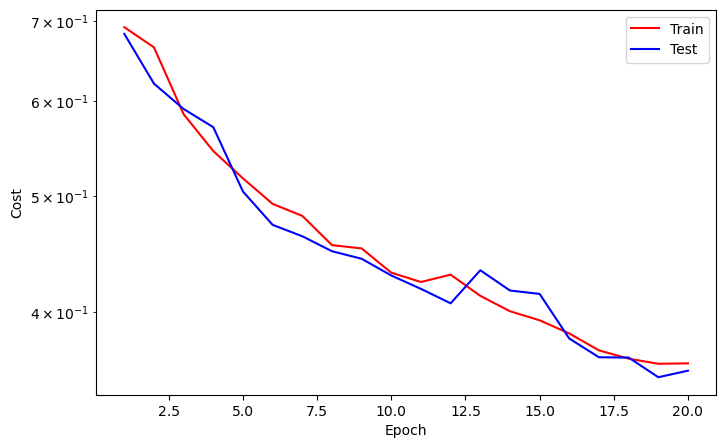

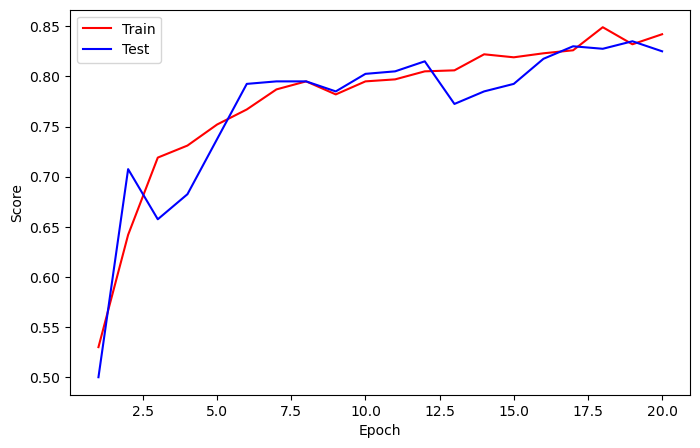

==> EarlyStop patience =  1 | Best test_score: 0.8350


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.3487 | Test_cost  = 0.3506 | Train_score = 0.8440 | Test_score = 0.8300 |
==> EarlyStop patience =  2 | Best test_score: 0.8350


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.3321 | Test_cost  = 0.4253 | Train_score = 0.8650 | Test_score = 0.8050 |
==> EarlyStop patience =  3 | Best test_score: 0.8350


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.3458 | Test_cost  = 0.3559 | Train_score = 0.8440 | Test_score = 0.8300 |
==> EarlyStop patience =  4 | Best test_score: 0.8350


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.3352 | Test_cost  = 0.3562 | Train_score = 0.8500 | Test_score = 0.8475 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 0.3296 | Test_cost  = 0.3486 | Train_score = 0.8650 | Test_score = 0.8375 |
==> EarlyStop patience =  1 | Best test_score: 0.8475


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 0.3213 | Test_cost  = 0.3365 | Train_score = 0.8600 | Test_score = 0.8400 |
==> EarlyStop patience =  2 | Best test_score: 0.8475


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 0.3095 | Test_cost  = 0.3294 | Train_score = 0.8670 | Test_score = 0.8650 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 0.3091 | Test_cost  = 0.3170 | Train_score = 0.8660 | Test_score = 0.8575 |
==> EarlyStop patience =  1 | Best test_score: 0.8650


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 0.3033 | Test_cost  = 0.3120 | Train_score = 0.8750 | Test_score = 0.8575 |
==> EarlyStop patience =  2 | Best test_score: 0.8650


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 0.3005 | Test_cost  = 0.3248 | Train_score = 0.8630 | Test_score = 0.8575 |
==> EarlyStop patience =  3 | Best test_score: 0.8650


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 0.3101 | Test_cost  = 0.3285 | Train_score = 0.8690 | Test_score = 0.8475 |
==> EarlyStop patience =  4 | Best test_score: 0.8650


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 0.3099 | Test_cost  = 0.3304 | Train_score = 0.8710 | Test_score = 0.8700 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 0.3000 | Test_cost  = 0.3093 | Train_score = 0.8770 | Test_score = 0.8475 |
==> EarlyStop patience =  1 | Best test_score: 0.8700


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 0.2863 | Test_cost  = 0.3012 | Train_score = 0.8830 | Test_score = 0.8600 |
==> EarlyStop patience =  2 | Best test_score: 0.8700


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 0.2892 | Test_cost  = 0.3297 | Train_score = 0.8690 | Test_score = 0.8700 |
==> EarlyStop patience =  3 | Best test_score: 0.8700


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 0.2931 | Test_cost  = 0.3171 | Train_score = 0.8780 | Test_score = 0.8450 |
==> EarlyStop patience =  4 | Best test_score: 0.8700


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 0.2896 | Test_cost  = 0.3079 | Train_score = 0.8920 | Test_score = 0.8550 |
==> EarlyStop patience =  5 | Best test_score: 0.8700
==> Execute Early Stopping at epoch: 37 | Best test_score: 0.8700
==> Best model is saved at model


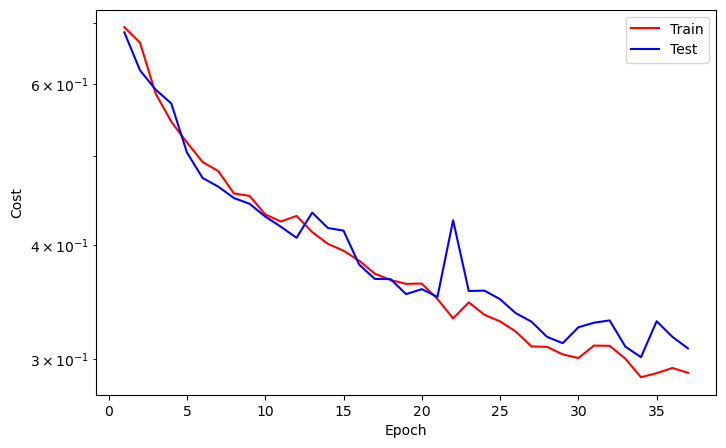

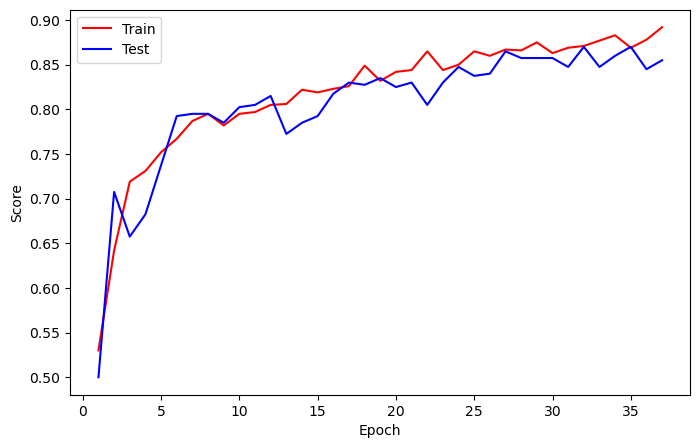

In [14]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

### Predict

In [15]:
feature, target = next(iter(testloader))
feature, target = feature.to(device) , target.to(device)

In [16]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds

tensor([0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
        0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')

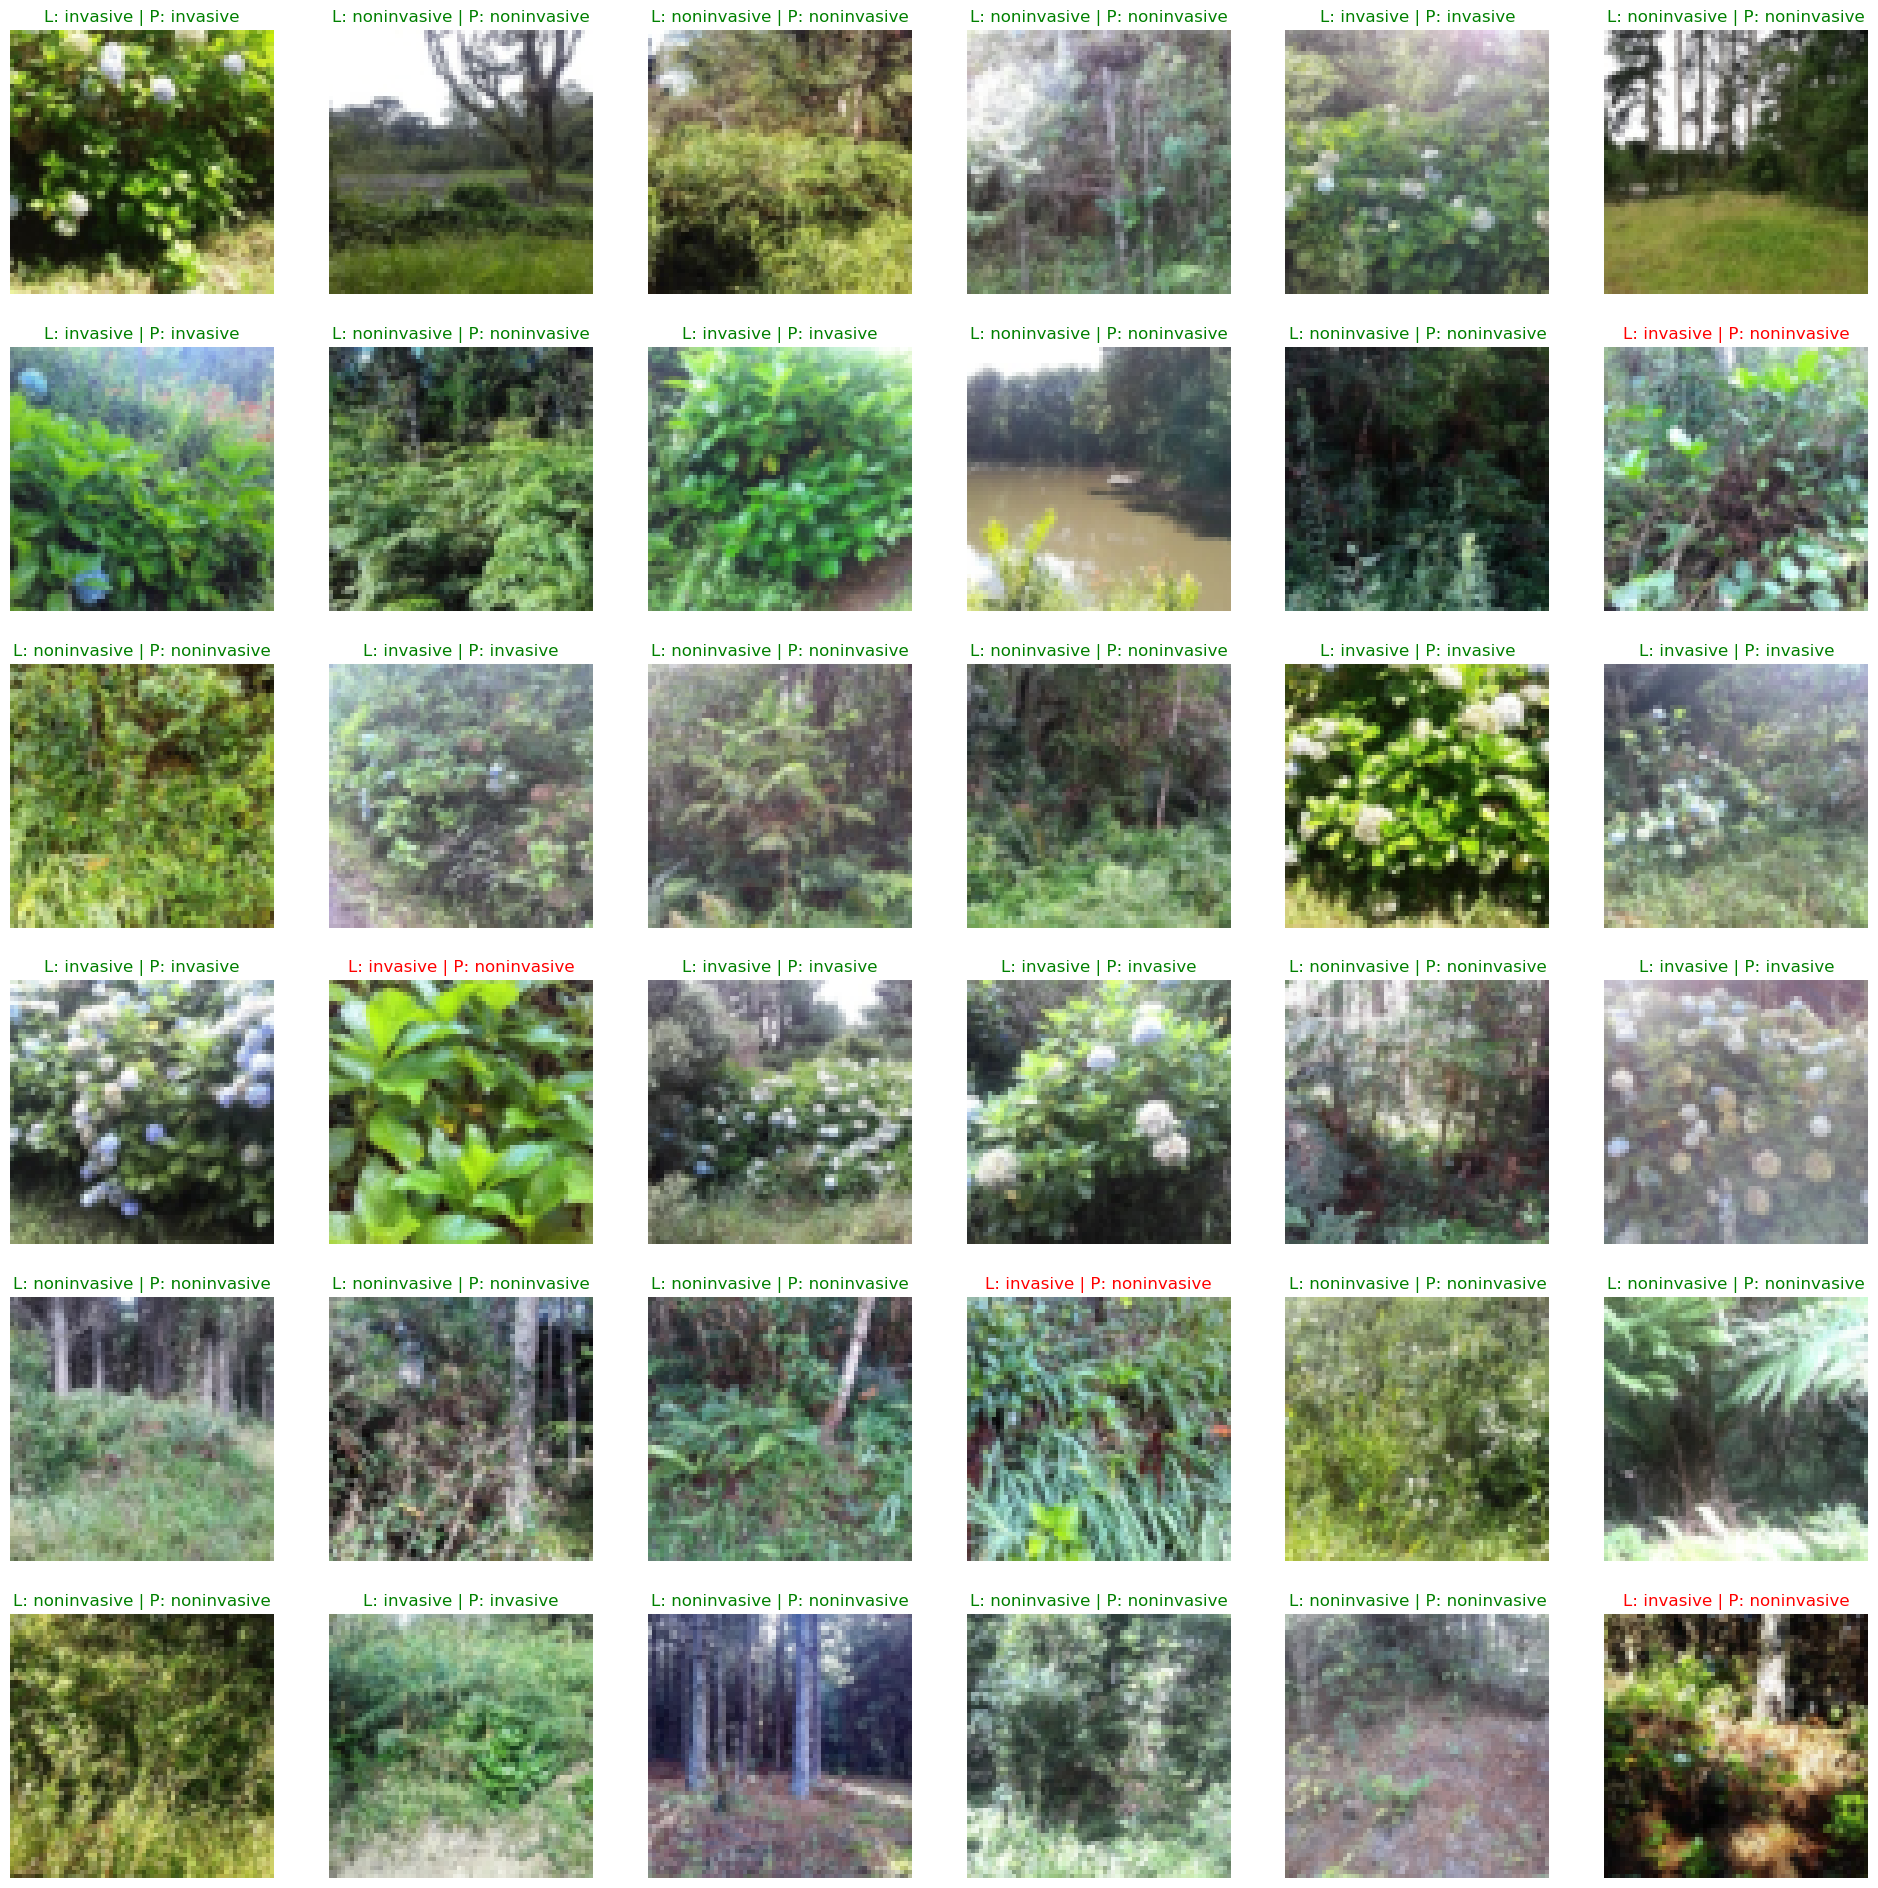

In [18]:
fig, axes = plt.subplots(6,6,figsize=(24,24))
for image, label, pred, ax in zip(feature,target,preds, axes.flatten()):
    ax.imshow(image.permute(1,2,0).cpu())
    font = {'color':'r'} if label != pred else {'color': 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title (f"L: {label} | P: {pred}",fontdict = font);
    ax.axis('off');